## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### Set seeds for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
print("="*70)
print("STEP-BY-STEP LSTM MODELING FOR TUBA FERMENTATION")
print("="*70)

STEP-BY-STEP LSTM MODELING FOR TUBA FERMENTATION


In [3]:
print("\n" + "="*70)
print("STEP 1: DATA LOADING")
print("="*70)


STEP 1: DATA LOADING


In [5]:
# Load your CSV file
df = pd.read_csv('filtered_readings.csv')

In [6]:
print(f"✓ Loaded {len(df)} readings")
print(f"\nDataset Info:")
print(df.info())
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nLast 5 rows:")
print(df.tail())
print(f"\nBasic statistics:")
print(df.describe())

✓ Loaded 846 readings

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                846 non-null    int64  
 1   batch_id          846 non-null    int64  
 2   gravity           846 non-null    float64
 3   temperature       846 non-null    float64
 4   battery           846 non-null    float64
 5   angle             846 non-null    float64
 6   timestamp         846 non-null    object 
 7   brix              846 non-null    float64
 8   date_only         846 non-null    object 
 9   interval_seconds  846 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 66.2+ KB
None

First 5 rows:
   id  batch_id   gravity  temperature   battery     angle  \
0   1         1  1.015740      30.1875  4.056309  31.13034   
1   2         1  1.014763      30.1875  4.056309  30.65194   
2   3         1  1.013954

In [7]:
print("\n" + "="*70)
print("STEP 2: DATA CLEANING")
print("="*70)


STEP 2: DATA CLEANING


In [8]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(f"✓ Converted timestamp to datetime format")

✓ Converted timestamp to datetime format


In [9]:
# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id                  0
batch_id            0
gravity             0
temperature         0
battery             0
angle               0
timestamp           0
brix                0
date_only           0
interval_seconds    0
dtype: int64


In [10]:
# Check for duplicate timestamps
duplicates = df.duplicated(subset=['timestamp']).sum()
print(f"\nDuplicate timestamps: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates(subset=['timestamp'], keep='first')
    print(f"✓ Removed {duplicates} duplicate readings")


Duplicate timestamps: 0


In [11]:
# Remove sensor errors (impossible values)
initial_count = len(df)

In [12]:
# Gravity range: 0.990 - 1.120 (typical fermentation range)
df = df[(df['gravity'] >= 0.990) & (df['gravity'] <= 1.120)]

# Temperature range: 15-40°C (realistic fermentation temperature)
df = df[(df['temperature'] >= 15) & (df['temperature'] <= 40)]

# Brix range: -5 to 25 (reasonable range)
df = df[(df['brix'] >= -5) & (df['brix'] <= 25)]

removed = initial_count - len(df)
print(f"\n✓ Removed {removed} readings with impossible values")
print(f"✓ Remaining readings: {len(df)}")


✓ Removed 0 readings with impossible values
✓ Remaining readings: 846


In [13]:
# Detect and remove outliers using IQR method
def remove_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    before = len(data)
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    after = len(data)
    
    print(f"  {column}: removed {before - after} outliers (range: {lower_bound:.4f} to {upper_bound:.4f})")
    return data

print(f"\nRemoving outliers using IQR method:")
df = remove_outliers_iqr(df, 'gravity', multiplier=2.0)
df = remove_outliers_iqr(df, 'temperature', multiplier=2.0)
df = remove_outliers_iqr(df, 'brix', multiplier=2.0)

print(f"\n✓ Final dataset after cleaning: {len(df)} readings")


Removing outliers using IQR method:
  gravity: removed 0 outliers (range: 0.9834 to 1.0216)
  temperature: removed 0 outliers (range: 24.5000 to 32.0000)
  brix: removed 0 outliers (range: -4.2856 to 5.5706)

✓ Final dataset after cleaning: 846 readings


In [14]:
print("\n" + "="*70)
print("STEP 3: HANDLING MISSING DATA")
print("="*70)


STEP 3: HANDLING MISSING DATA


In [15]:
# Sort by timestamp to ensure proper interpolation
df = df.sort_values('timestamp').reset_index(drop=True)
print(f"✓ Sorted data by timestamp")

✓ Sorted data by timestamp


In [16]:
# Check for time gaps (missed transmissions)
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
expected_interval = 15  # seconds
tolerance = 5  # seconds

In [17]:
large_gaps = df[df['time_diff'] > (expected_interval + tolerance)]
print(f"\nDetected {len(large_gaps)} time gaps larger than {expected_interval + tolerance} seconds")

if len(large_gaps) > 0:
    print(f"Largest gap: {df['time_diff'].max():.1f} seconds")


Detected 27 time gaps larger than 20 seconds
Largest gap: 19992.4 seconds


In [19]:
# Interpolate missing values (if any NaN values exist after cleaning)
numeric_cols = ['gravity', 'temperature', 'brix']
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].interpolate(method='linear', limit=3)
        print(f"✓ Interpolated missing values in {col}")

In [20]:
# Forward fill any remaining NaN at start
df = df.fillna(method='bfill')


In [21]:
# Backward fill any remaining NaN at end
df = df.fillna(method='ffill')

In [22]:
print(f"\n✓ All missing values handled")
print(f"Remaining NaN values: {df.isnull().sum().sum()}")


✓ All missing values handled
Remaining NaN values: 0


In [23]:
print("\n" + "="*70)
print("STEP 4: FEATURE ENGINEERING")
print("="*70)



STEP 4: FEATURE ENGINEERING


In [24]:
# 4.1: Time-based features
batch_start = df['timestamp'].iloc[0]
df['hours_elapsed'] = (df['timestamp'] - batch_start).dt.total_seconds() / 3600
print(f"✓ Created 'hours_elapsed' feature")

✓ Created 'hours_elapsed' feature


In [25]:
# 4.2: Verify/Recalculate Brix (if needed)
# You already have brix in your CSV, but let's verify it's correct
# SG -> Brix formula: Brix = (((182.4601 * SG - 775.6821) * SG + 1262.7794) * SG - 669.5622)
def sg_to_brix(sg):
    """Convert Specific Gravity to Brix using standard formula"""
    return (((182.4601 * sg - 775.6821) * sg + 1262.7794) * sg - 669.5622)

# Verify existing brix values (optional - your CSV already has brix)
df['brix_verified'] = df['gravity'].apply(sg_to_brix)

# Compare if significantly different
brix_diff = abs(df['brix'] - df['brix_verified']).mean()
if brix_diff > 0.1:
    print(f"⚠️  Warning: Brix values differ by {brix_diff:.4f} on average")
    print(f"   Using verified brix from SG conversion")
    df['brix'] = df['brix_verified']
else:
    print(f"✓ Brix values verified (avg diff: {brix_diff:.4f})")

df.drop('brix_verified', axis=1, inplace=True)

✓ Brix values verified (avg diff: 0.0000)


In [26]:
# 4.3: Calculate alcohol content using proper formula
# Method 1: Standard ABV formula from OG and FG
# ABV = (OG - FG) × 131.25
# For tuba, we need to determine Original Gravity (OG) from first reading
ORIGINAL_GRAVITY = df['gravity'].iloc[0]  # First reading is your OG
print(f"✓ Original Gravity (OG): {ORIGINAL_GRAVITY:.4f}")

df['alcohol'] = (ORIGINAL_GRAVITY - df['gravity']) * 131.25
df['alcohol'] = df['alcohol'].clip(lower=0)  # No negative alcohol

# Alternative Method 2: Using Brix for alcohol calculation
# More accurate for sugar-based fermentation (tuba is coconut sap sugar)
# ABV ≈ (Starting Brix - Final Brix) × 0.59
# This accounts for the fact that not all sugar converts to alcohol
ORIGINAL_BRIX = df['brix'].iloc[0]  # First reading
df['alcohol_from_brix'] = (ORIGINAL_BRIX - df['brix']) * 0.59
df['alcohol_from_brix'] = df['alcohol_from_brix'].clip(lower=0)

print(f"✓ Calculated 'alcohol' content (ABV %) using SG method")
print(f"✓ Calculated 'alcohol_from_brix' using Brix method (more accurate for tuba)")
print(f"   Original Brix: {ORIGINAL_BRIX:.2f}°Bx")
print(f"   Final Brix: {df['brix'].iloc[-1]:.2f}°Bx")
print(f"   Estimated final ABV: {df['alcohol'].iloc[-1]:.2f}% (SG method)")
print(f"   Estimated final ABV: {df['alcohol_from_brix'].iloc[-1]:.2f}% (Brix method)")


✓ Original Gravity (OG): 1.0157
✓ Calculated 'alcohol' content (ABV %) using SG method
✓ Calculated 'alcohol_from_brix' using Brix method (more accurate for tuba)
   Original Brix: 4.01°Bx
   Final Brix: -0.21°Bx
   Estimated final ABV: 2.17% (SG method)
   Estimated final ABV: 2.49% (Brix method)


In [27]:
# 4.3: Rate of change features (velocity)
df['gravity_velocity'] = df['gravity'].diff() / df['hours_elapsed'].diff()
df['temp_velocity'] = df['temperature'].diff() / df['hours_elapsed'].diff()
df['brix_velocity'] = df['brix'].diff() / df['hours_elapsed'].diff()
df['alcohol_velocity'] = df['alcohol'].diff() / df['hours_elapsed'].diff()
print(f"✓ Calculated velocity features (rate of change)")

✓ Calculated velocity features (rate of change)


In [28]:
# 4.4: Acceleration features (change in velocity)
df['gravity_acceleration'] = df['gravity_velocity'].diff() / df['hours_elapsed'].diff()
df['temp_acceleration'] = df['temp_velocity'].diff() / df['hours_elapsed'].diff()
print(f"✓ Calculated acceleration features")

✓ Calculated acceleration features


In [29]:
# 4.5: Moving averages (smoothing)
window_sizes = [5, 10, 20]
for window in window_sizes:
    df[f'gravity_ma{window}'] = df['gravity'].rolling(window=window, min_periods=1).mean()
    df[f'temp_ma{window}'] = df['temperature'].rolling(window=window, min_periods=1).mean()
    df[f'brix_ma{window}'] = df['brix'].rolling(window=window, min_periods=1).mean()
print(f"✓ Calculated moving averages (windows: {window_sizes})")

✓ Calculated moving averages (windows: [5, 10, 20])


In [30]:
# 4.6: Standard deviation (volatility)
for window in [10, 20]:
    df[f'gravity_std{window}'] = df['gravity'].rolling(window=window, min_periods=1).std()
    df[f'temp_std{window}'] = df['temperature'].rolling(window=window, min_periods=1).std()
print(f"✓ Calculated rolling standard deviations")

✓ Calculated rolling standard deviations


In [37]:
# 4.7: Cumulative features
df['gravity_cumsum'] = df['gravity'].cumsum()
df['gravity_change_cumsum'] = (ORIGINAL_GRAVITY - df['gravity']).cumsum()
print(f"✓ Calculated cumulative features")

# Fill any NaN created by diff() and rolling operations
df = df.fillna(method='bfill').fillna(method='ffill')

print(f"\n✓ Total features created: {len(df.columns)}")
print(f"Feature columns: {list(df.columns)}")

✓ Calculated cumulative features

✓ Total features created: 36
Feature columns: ['id', 'batch_id', 'gravity', 'temperature', 'battery', 'angle', 'timestamp', 'brix', 'date_only', 'interval_seconds', 'time_diff', 'hours_elapsed', 'alcohol', 'alcohol_from_brix', 'gravity_velocity', 'temp_velocity', 'brix_velocity', 'alcohol_velocity', 'gravity_acceleration', 'temp_acceleration', 'gravity_ma5', 'temp_ma5', 'brix_ma5', 'gravity_ma10', 'temp_ma10', 'brix_ma10', 'gravity_ma20', 'temp_ma20', 'brix_ma20', 'gravity_std10', 'temp_std10', 'gravity_std20', 'temp_std20', 'is_fermented', 'gravity_cumsum', 'gravity_change_cumsum']


In [38]:
print("\n" + "="*70)
print("STEP 5: LABEL CREATION")
print("="*70)


STEP 5: LABEL CREATION


In [39]:
# Your fermentation split point
FERMENTATION_SPLIT = 717  # Reading 717 is where fermentation starts

In [40]:
# Create binary labels
df['is_fermented'] = 0  # Default: Not Fermented
df.loc[FERMENTATION_SPLIT:, 'is_fermented'] = 1  # After reading 816: Fermented

not_fermented_count = (df['is_fermented'] == 0).sum()
fermented_count = (df['is_fermented'] == 1).sum()

print(f"✓ Labels created:")
print(f"  - Not Fermented (Class 0): {not_fermented_count} readings")
print(f"  - Fermented (Class 1): {fermented_count} readings")
print(f"  - Class imbalance ratio: {not_fermented_count/fermented_count:.2f}:1")

✓ Labels created:
  - Not Fermented (Class 0): 717 readings
  - Fermented (Class 1): 129 readings
  - Class imbalance ratio: 5.56:1


In [41]:
print("\n" + "="*70)
print("STEP 6: SEQUENCE CREATION FOR LSTM")
print("="*70)


STEP 6: SEQUENCE CREATION FOR LSTM


In [42]:
# Define sequence length (number of timesteps LSTM will look at)
SEQUENCE_LENGTH = 132  # Your Day 2 (fermented) length

In [43]:
# Select features for LSTM input
feature_columns = [
    # Core measurements
    'gravity', 'temperature', 'brix', 'hours_elapsed',
    
    # Alcohol calculations (using Brix method - more accurate for tuba)
    'alcohol_from_brix',  # Primary alcohol estimate
    
    # Velocities (rate of change)
    'gravity_velocity', 'temp_velocity', 'brix_velocity', 'alcohol_velocity',
    
    # Accelerations
    'gravity_acceleration', 'temp_acceleration',
    
    # Moving averages (5, 10, 20)
    'gravity_ma5', 'temp_ma5', 'brix_ma5',
    'gravity_ma10', 'temp_ma10', 'brix_ma10',
    'gravity_ma20', 'temp_ma20', 'brix_ma20',
    
    # Standard deviations
    'gravity_std10', 'temp_std10',
    'gravity_std20', 'temp_std20',
    
    # Cumulative
    'gravity_cumsum', 'gravity_change_cumsum'
]

print(f"✓ Using {len(feature_columns)} features for LSTM")
print(f"✓ Sequence length: {SEQUENCE_LENGTH} timesteps")

✓ Using 26 features for LSTM
✓ Sequence length: 132 timesteps


In [44]:
# Create sequences using sliding window
def create_sequences(data, feature_cols, label_col, seq_length, stride=10):
    """
    Create overlapping sequences for LSTM training
    
    Parameters:
    -----------
    data : DataFrame
    feature_cols : list of feature column names
    label_col : str, label column name
    seq_length : int, number of timesteps per sequence
    stride : int, how many timesteps to move window (smaller = more sequences)
    
    Returns:
    --------
    X : array of shape (n_sequences, seq_length, n_features)
    y : array of shape (n_sequences,)
    """
    X_list = []
    y_list = []
    
    X_data = data[feature_cols].values
    
    for i in range(0, len(X_data) - seq_length + 1, stride):
        # Extract sequence
        sequence = X_data[i:i + seq_length]
        
        # Label is from the LAST reading in the sequence
        label_idx = i + seq_length - 1
        label = data.iloc[label_idx][label_col]
        
        X_list.append(sequence)
        y_list.append(label)
    
    return np.array(X_list), np.array(y_list)

In [45]:
# Create sequences with stride=10 (overlap for more training samples)
X, y = create_sequences(
    df, 
    feature_columns, 
    'is_fermented', 
    SEQUENCE_LENGTH, 
    stride=10
)

print(f"\n✓ Created sequences:")
print(f"  - Total sequences: {len(X)}")
print(f"  - Shape: {X.shape} (sequences, timesteps, features)")
print(f"  - Not Fermented sequences: {(y == 0).sum()}")
print(f"  - Fermented sequences: {(y == 1).sum()}")
print(f"  - Class imbalance: {(y == 0).sum() / (y == 1).sum():.2f}:1")


✓ Created sequences:
  - Total sequences: 72
  - Shape: (72, 132, 26) (sequences, timesteps, features)
  - Not Fermented sequences: 59
  - Fermented sequences: 13
  - Class imbalance: 4.54:1


In [46]:
print("\n" + "="*70)
print("STEP 7: NORMALIZATION")
print("="*70)


STEP 7: NORMALIZATION


In [47]:
# Split data first (important: normalize after split to prevent data leakage!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"✓ Data split:")
print(f"  - Training set: {len(X_train)} sequences ({(y_train==0).sum()} Not Ferm, {(y_train==1).sum()} Ferm)")
print(f"  - Test set: {len(X_test)} sequences ({(y_test==0).sum()} Not Ferm, {(y_test==1).sum()} Ferm)")

✓ Data split:
  - Training set: 57 sequences (47 Not Ferm, 10 Ferm)
  - Test set: 15 sequences (12 Not Ferm, 3 Ferm)


In [48]:
# Initialize scaler
scaler = StandardScaler()

# Reshape for scaling: (samples * timesteps, features)
n_samples_train, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)

# Transform test data (using fitted scaler)
n_samples_test = X_test.shape[0]
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)

print(f"\n✓ Normalization completed using StandardScaler")
print(f"  - Mean: ~0, Std: ~1 for all features")


✓ Normalization completed using StandardScaler
  - Mean: ~0, Std: ~1 for all features


In [49]:
# Save scaler for production use
joblib.dump(scaler, 'tuba_scaler.pkl')
print(f"✓ Scaler saved to 'tuba_scaler.pkl'")

✓ Scaler saved to 'tuba_scaler.pkl'


In [50]:
print("\n" + "="*70)
print("STEP 8: HANDLING CLASS IMBALANCE")
print("="*70)


STEP 8: HANDLING CLASS IMBALANCE


In [51]:
# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"✓ Calculated class weights:")
print(f"  - Class 0 (Not Fermented): {class_weights[0]:.4f}")
print(f"  - Class 1 (Fermented): {class_weights[1]:.4f}")
print(f"  → Model will penalize wrong 'Fermented' predictions {class_weights[1]/class_weights[0]:.2f}x more")

✓ Calculated class weights:
  - Class 0 (Not Fermented): 0.6064
  - Class 1 (Fermented): 2.8500
  → Model will penalize wrong 'Fermented' predictions 4.70x more


In [52]:
print("\n" + "="*70)
print("STEP 9: BUILDING LSTM MODEL")
print("="*70)


STEP 9: BUILDING LSTM MODEL


In [53]:
def build_lstm_model(seq_length, n_features):
    """
    Build LSTM architecture with regularization
    """
    model = Sequential([
        # First LSTM layer - captures long-term dependencies
        LSTM(
            128, 
            return_sequences=True,
            input_shape=(seq_length, n_features),
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)
        ),
        Dropout(0.3),
        BatchNormalization(),
        
        # Second LSTM layer - refines patterns
        LSTM(
            64,
            return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)
        ),
        Dropout(0.3),
        BatchNormalization(),
        
        # Third LSTM layer - final feature extraction
        LSTM(
            32,
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01)
        ),
        Dropout(0.2),
        
        # Dense layers for classification
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        
        # Output layer - binary classification
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

In [54]:
# Build model
model = build_lstm_model(SEQUENCE_LENGTH, n_features)

print(f"✓ LSTM model architecture:")
model.summary()

print(f"\n✓ Model configuration:")
print(f"  - LSTM layers: 3 (128 → 64 → 32 units)")
print(f"  - Dropout rate: 0.2-0.3 (prevents overfitting)")
print(f"  - L2 regularization: 0.01 (weight decay)")
print(f"  - Optimizer: Adam (learning rate = 0.001)")
print(f"  - Loss: Binary crossentropy")

✓ LSTM model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 132, 128)       │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 132, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 132, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 132, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 132, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,497 (556.63 KB)

 Trainable params: 142,113 (555.13 KB)

 Non-trainable params: 384 (1.50 KB)


✓ Model configuration:
  - LSTM layers: 3 (128 → 64 → 32 units)
  - Dropout rate: 0.2-0.3 (prevents overfitting)
  - L2 regularization: 0.01 (weight decay)
  - Optimizer: Adam (learning rate = 0.001)
  - Loss: Binary crossentropy


In [55]:
print("\n" + "="*70)
print("STEP 10: TRAINING WITH FINE-TUNING")
print("="*70)


STEP 10: TRAINING WITH FINE-TUNING


In [56]:
# Define callbacks for fine-tuning
callbacks = [
    # Early stopping - stop if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # Wait 15 epochs before stopping
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when learning plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=7,  # Wait 7 epochs before reducing
        min_lr=1e-6,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'tuba_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(f"✓ Callbacks configured:")
print(f"  - EarlyStopping: patience=15")
print(f"  - ReduceLROnPlateau: factor=0.5, patience=7")
print(f"  - ModelCheckpoint: save best model to 'tuba_lstm_model.h5'")

✓ Callbacks configured:
  - EarlyStopping: patience=15
  - ReduceLROnPlateau: factor=0.5, patience=7
  - ModelCheckpoint: save best model to 'tuba_lstm_model.h5'


In [57]:
# Train model
print(f"\nStarting training...")
print(f"="*70)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,  # Handle class imbalance
    callbacks=callbacks,
    verbose=1
)

print(f"\n" + "="*70)
print(f"✓ TRAINING COMPLETED!")
print(f"="*70)



Starting training...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7717 - auc: 0.5320 - loss: 6.1830 - precision: 0.2500 - recall: 0.2000      
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to tuba_lstm_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 907ms/step - accuracy: 0.7893 - auc: 0.5834 - loss: 6.1703 - precision: 0.3333 - recall: 0.2667 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 6.0015 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9668 - auc: 0.9920 - loss: 5.8278 - precision: 0.9500 - recall: 0.8500
Epoch 2: val_accuracy did not improve from 1.00000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9662 - auc: 0.9919 - loss: 5.8237 - precision: 0.9333 - recall: 0.8667 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 5.8077 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9756 - auc: 1.0000 - loss: 5.6105 - precision: 0.8712 - recall: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9779 - auc: 1.0000 - loss: 5.6084 - precision: 0.8838 - recall: 1.000

In [58]:
print("\n" + "="*70)
print("STEP 11: MODEL EVALUATION")
print("="*70)


STEP 11: MODEL EVALUATION


In [59]:
# Load best model
model = tf.keras.models.load_model('tuba_lstm_model.h5')
print(f"✓ Loaded best model from checkpoint")

✓ Loaded best model from checkpoint


In [60]:
# Make predictions
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

In [61]:
# Classification report
print(f"\n📊 CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(
    y_test, y_pred,
    target_names=['Not Fermented', 'Fermented'],
    digits=4
))


📊 CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Not Fermented     1.0000    1.0000    1.0000        12
    Fermented     1.0000    1.0000    1.0000         3

     accuracy                         1.0000        15
    macro avg     1.0000    1.0000    1.0000        15
 weighted avg     1.0000    1.0000    1.0000        15



In [62]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 CONFUSION MATRIX:")
print("="*70)
print(f"                  Predicted")
print(f"                  Not Ferm  Fermented")
print(f"Actual Not Ferm      {cm[0][0]:4d}      {cm[0][1]:4d}")
print(f"Actual Fermented     {cm[1][0]:4d}      {cm[1][1]:4d}")


📊 CONFUSION MATRIX:
                  Predicted
                  Not Ferm  Fermented
Actual Not Ferm        12         0
Actual Fermented        0         3


In [63]:
# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n📊 DETAILED METRICS:")
print("="*70)
print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:   {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:      {recall:.4f} ({recall*100:.2f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"F1-Score:    {f1:.4f}")


📊 DETAILED METRICS:
Accuracy:    1.0000 (100.00%)
Precision:   1.0000 (100.00%)
Recall:      1.0000 (100.00%)
Specificity: 1.0000 (100.00%)
F1-Score:    1.0000


In [64]:
# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC:     {roc_auc:.4f}")

ROC-AUC:     1.0000


In [65]:
print("\n" + "="*70)
print("STEP 12: CREATING VISUALIZATIONS")
print("="*70)


STEP 12: CREATING VISUALIZATIONS


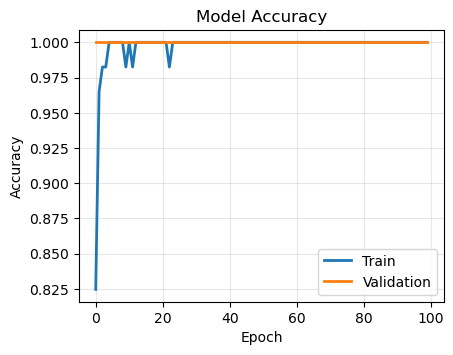

In [66]:
fig = plt.figure(figsize=(16, 12))

# 1. Training History - Accuracy
ax1 = plt.subplot(3, 3, 1)
ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

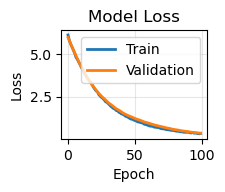

In [67]:
# 2. Training History - Loss
ax2 = plt.subplot(3, 3, 2)
ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

Text(0.5, 1.0, 'Confusion Matrix')

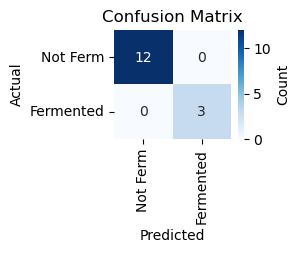

In [68]:
# 3. Confusion Matrix
ax3 = plt.subplot(3, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Not Ferm', 'Fermented'],
            yticklabels=['Not Ferm', 'Fermented'],
            cbar_kws={'label': 'Count'})
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title('Confusion Matrix')

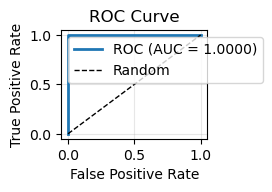

In [69]:
# 4. ROC Curve
ax4 = plt.subplot(3, 3, 4)
ax4.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve')
ax4.legend()
ax4.grid(True, alpha=0.3)